In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from fit import *
from NEF_RL import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Simulate RL_n and bayes_n with different amounts of noise $\sigma$

In [2]:
def run_bayesn(sid, noise):
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    params = [noise, 0]
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    for trial in human['trial'].unique():
        for stage in human['stage'].unique():
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = get_expectations_carrabin("bayes_n", params, sid, trial, stage)
            dfs.append(pd.DataFrame([["bayes_n", sid, trial, stage, qid, response]], columns=columns))
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['noise'] = noise
    return dynamics_data

In [3]:
def run_RLn(sid, sigma):
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    params = [mu, sigma]
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    for trial in human['trial'].unique():
        for stage in human['stage'].unique():
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = get_expectations_carrabin("RL_n", params, sid, trial, stage)
            dfs.append(pd.DataFrame([["RL_n", sid, trial, stage, qid, response]], columns=columns))
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['sigma'] = sigma
    return dynamics_data

In [4]:
sid = 18
noises = [0.2, 0.3, 0.5]
dfs = []
for noise in noises:
    dfs.append(run_bayesn(sid, noise))
bayesn_data = pd.concat(dfs, ignore_index=True)

In [5]:
sid = 18
sigmas = [0.03, 0.05, 0.10]
dfs = []
for sigma in sigmas:
    dfs.append(run_RLn(sid, sigma))
RLn_data = pd.concat(dfs, ignore_index=True)

# Simulate NEF_RL with different $n_{error}$

In [6]:
def run_NEFRL(sid, n_error):
    # mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    mu = pd.read_pickle(f"data/NEF_RL_carrabin_feb17_params.pkl").query("sid==@sid")['mu'].unique()[0]
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    trials = human['trial'].unique() 
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    dfs = []
    for trial in trials:
        print(f"n_error {n_error}, sid {sid}, trial {trial}")
        env = Environment(dataset="carrabin", sid=sid, trial=trial, decay="stages", s=[mu,mu,mu,mu,mu])
        seed_net = sid + 1000*trial
        net = build_network_RL(env, n_error=n_error, seed_net=seed_net, z=0, a=5e-5)
        sim = nengo.Simulator(net, seed=trial, progress_bar=False)
        with sim:
            sim.run(env.Tall, progress_bar=False)
        for stage in env.stages:
            tidx = int((stage*env.T)/env.dt)-2
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = sim.data[net.probe_value][tidx][0]
            df = pd.DataFrame([['NEF_RL', sid, trial, stage, qid, response]], columns=columns)
            dfs.append(df)
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['n_error'] = n_error
    return dynamics_data

In [7]:
sid = 18
n_error = [50, 100, 400]
for e in n_error:
    dfs.append(run_NEFRL(sid, e))
NEFRL_data = pd.concat(dfs, ignore_index=True)

n_error 50, sid 18, trial 1
n_error 50, sid 18, trial 2
n_error 50, sid 18, trial 3
n_error 50, sid 18, trial 4
n_error 50, sid 18, trial 5
n_error 50, sid 18, trial 6
n_error 50, sid 18, trial 7
n_error 50, sid 18, trial 8
n_error 50, sid 18, trial 9
n_error 50, sid 18, trial 10
n_error 50, sid 18, trial 11
n_error 50, sid 18, trial 12
n_error 50, sid 18, trial 13
n_error 50, sid 18, trial 14
n_error 50, sid 18, trial 15
n_error 50, sid 18, trial 16
n_error 50, sid 18, trial 17
n_error 50, sid 18, trial 18
n_error 50, sid 18, trial 19
n_error 50, sid 18, trial 20
n_error 50, sid 18, trial 21
n_error 50, sid 18, trial 22
n_error 50, sid 18, trial 23
n_error 50, sid 18, trial 24
n_error 50, sid 18, trial 25
n_error 50, sid 18, trial 26
n_error 50, sid 18, trial 27
n_error 50, sid 18, trial 28
n_error 50, sid 18, trial 29
n_error 50, sid 18, trial 30
n_error 50, sid 18, trial 31
n_error 50, sid 18, trial 32
n_error 50, sid 18, trial 33
n_error 50, sid 18, trial 34
n_error 50, sid 18, tri

### Compare distribution of alpha, excursions vs above noise parameters

In [8]:
def add_excursion_alpha2(data, noise_label):
    dfs = []
    for mt in data['type'].unique():
        for sid in data['sid'].unique():
            human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
            for n in data[noise_label].unique():
                subdata = data.query(f"type==@mt & sid==@sid & {noise_label}==@n").copy()
                print(f"{mt} sid {sid}, {noise_label} {n}")
                for i, row in subdata.iterrows():
                    trial = row['trial']
                    stage = row['stage']
                    qid = row['qid']
                    response = row['response']
                    avg_response = subdata.query("qid==@qid")['response'].mean()
                    subdata.loc[i, 'excursion'] = response - avg_response
                    if stage>1:
                        stage_old = stage - 1
                        response_old = subdata.query("trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
                        delta = response_old - response
                        color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
                        prediction_error = color - response_old
                        alpha = np.abs(delta / prediction_error) if prediction_error!=0 else 0
                        subdata.loc[i, 'alpha'] = alpha
                dfs.append(subdata)
    data_add = pd.concat(dfs, ignore_index=True)
    return data_add

In [9]:
rln_add = add_excursion_alpha2(RLn_data, 'sigma')
bayesn_add = add_excursion_alpha2(bayesn_data, 'noise')
nefrl_add = add_excursion_alpha2(NEFRL_data, 'n_error')
human = pd.read_pickle("data/carrabin.pkl").query("sid==@sid")
human['sigma'] = 'human'
human_add = add_excursion_alpha2(human, 'sigma')
human_add['noise'] = 'human'
human_add['n_error'] = 'human'
combined = pd.concat([human_add, bayesn_add, rln_add, nefrl_add], ignore_index=True)

RL_n sid 18, sigma 0.03
RL_n sid 18, sigma 0.05
RL_n sid 18, sigma 0.1
bayes_n sid 18, noise 0.2
bayes_n sid 18, noise 0.3
bayes_n sid 18, noise 0.5
RL_n sid 18, n_error nan
RL_n sid 18, n_error 50.0
RL_n sid 18, n_error 100.0
RL_n sid 18, n_error 400.0
NEF_RL sid 18, n_error nan
NEF_RL sid 18, n_error 50.0
NEF_RL sid 18, n_error 100.0
NEF_RL sid 18, n_error 400.0
human sid 18, sigma human


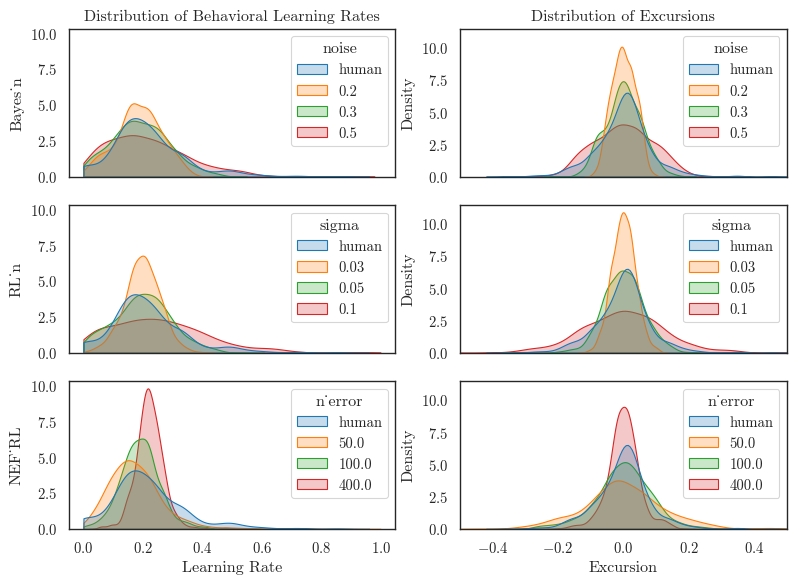

In [10]:
# with sns.axes_style("whitegrid"):
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 6), sharex='col', sharey='col')
bayes_query = ['human', 'bayes_n']
rl_query = ['human', 'RL_n']
nef_query = ['human', 'NEF_RL']
sns.kdeplot(combined.query("type==@bayes_query"), x='alpha', hue='noise', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@rl_query"), x='alpha', hue='sigma', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nef_query"), x='alpha', hue='n_error', ax=axes[2][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@bayes_query"), x='excursion', hue='noise', ax=axes[0][1], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@rl_query"), x='excursion', hue='sigma', ax=axes[1][1], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type==@nef_query"), x='excursion', hue='n_error', ax=axes[2][1], clip=[-1, 1], palette=palette[:4], fill=True, common_norm=False)
axes[0][0].set(title='Distribution of Behavioral Learning Rates')
axes[0][1].set(title='Distribution of Excursions')
axes[0][0].set(ylabel='Bayes_n')
axes[1][0].set(ylabel='RL_n')
axes[2][0].set(ylabel='NEF_RL')
axes[2][0].set(xlabel="Learning Rate")
axes[2][1].set(xlabel='Excursion', xlim=[-0.5, 0.5])
plt.tight_layout()
fig.savefig("plots/noise_demo_all_model_types.jpg", dpi=600)

## Load and Plot

In [11]:
noise_data = pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb17.pkl")
# noise_data = pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb14all.pkl")
# noise_data = pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb13five.pkl")
# noise_data = pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb13four.pkl")
# noise_data = pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb13three.pkl")
# noise_data = pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb13test.pkl")

In [12]:
def add_excursion_alpha(data):
    dfs = []
    for mt in data['type'].unique():
        for sid in data['sid'].unique():
            human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
            for l in data['n_learning'].unique():
                for e in data['n_error'].unique():
                    subdata = data.query("type==@mt & sid==@sid & n_learning==@l & n_error==@e").copy()
                    print(f"{mt} sid {sid}, n_learning {l}, n_error {e}")
                    for i, row in subdata.iterrows():
                        trial = row['trial']
                        stage = row['stage']
                        qid = row['qid']
                        response = row['response']
                        avg_response = subdata.query("qid==@qid")['response'].mean()
                        subdata.loc[i, 'excursion'] = response - avg_response
                        if stage>1:
                            stage_old = stage - 1
                            response_old = subdata.query("trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
                            delta = response_old - response
                            color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
                            prediction_error = color - response_old
                            alpha = np.abs(delta / prediction_error) if prediction_error!=0 else 0
                            subdata.loc[i, 'alpha'] = alpha
                    dfs.append(subdata)
    data_add = pd.concat(dfs, ignore_index=True)
    return data_add

In [19]:
# def add_excursion_alpha(data):
#     dfs = []
#     human = pd.read_pickle(f"data/carrabin.pkl")
#     sid_old = None
#     for i, row in data.iterrows():
#         mt = row['type']
#         sid = row['sid']
#         l = row['n_learning']
#         e = row['n_error']
#         trial = row['trial']
#         stage = row['stage']
#         qid = row['qid']
#         response = row['response']
#         avg_response = data.query("type==@mt & sid==@sid & n_learning==@l & n_error==@e & qid==@qid")['response'].mean()
#         data.loc[i, 'excursion'] = response - avg_response
#         if stage>1:
#             stage_old = stage - 1
#             response_old = data.query("type==@mt & sid==@sid & n_learning==@l & n_error==@e & trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
#             delta = response_old - response
#             color = human.query("sid==@sid & trial==@trial & stage==@stage")['color'].to_numpy()[0]
#             prediction_error = color - response_old
#             alpha = np.abs(delta / prediction_error) if prediction_error!=0 else 0
#             data.loc[i, 'alpha'] = alpha
#         if sid!=sid_old: print(f"sid {sid}")
#         sid_old = sid
#     return data

In [13]:
combined = add_excursion_alpha(noise_data)

NEF_RL sid 1, n_learning 50, n_error 50
NEF_RL sid 1, n_learning 50, n_error 75
NEF_RL sid 1, n_learning 50, n_error 100
NEF_RL sid 1, n_learning 50, n_error 200
NEF_RL sid 1, n_learning 50, n_error 400
NEF_RL sid 1, n_learning 75, n_error 50
NEF_RL sid 1, n_learning 75, n_error 75
NEF_RL sid 1, n_learning 75, n_error 100
NEF_RL sid 1, n_learning 75, n_error 200
NEF_RL sid 1, n_learning 75, n_error 400
NEF_RL sid 1, n_learning 100, n_error 50
NEF_RL sid 1, n_learning 100, n_error 75
NEF_RL sid 1, n_learning 100, n_error 100
NEF_RL sid 1, n_learning 100, n_error 200
NEF_RL sid 1, n_learning 100, n_error 400
NEF_RL sid 1, n_learning 200, n_error 50
NEF_RL sid 1, n_learning 200, n_error 75
NEF_RL sid 1, n_learning 200, n_error 100
NEF_RL sid 1, n_learning 200, n_error 200
NEF_RL sid 1, n_learning 200, n_error 400
NEF_RL sid 1, n_learning 400, n_error 50
NEF_RL sid 1, n_learning 400, n_error 75
NEF_RL sid 1, n_learning 400, n_error 100
NEF_RL sid 1, n_learning 400, n_error 200
NEF_RL sid 1

In [14]:
combined.to_pickle("data/alpha_excursions_feb17.pkl")

In [13]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharex='col', sharey='col')
# sns.kdeplot(combined_add.query("type=='NEF_RL'"), x='alpha', hue='n_learning', ax=axes[0][0], clip=[0, 1], palette=palette[:5], fill=True, common_norm=False)
# sns.kdeplot(combined_add.query("type=='NEF_RL'"), x='alpha', hue='n_error', ax=axes[1][0], clip=[0, 1], palette=palette[:5], fill=True, common_norm=False)
# sns.kdeplot(combined_add.query("type=='NEF_RL'"), x='excursion', hue='n_learning', ax=axes[0][1], palette=palette[:5], fill=True, common_norm=False)
# sns.kdeplot(combined_add.query("type=='NEF_RL'"), x='excursion', hue='n_error', ax=axes[1][1], palette=palette[:5], fill=True, common_norm=False)
# axes[0][0].set(title='Distribution of Behavioral Learning Rates')
# axes[0][1].set(title='Distribution of Excursions', xlabel="Excursion", ylabel=None, xlim=[-0.5,0.5])
# axes[1][0].set(xlabel="Learning Rate")
# axes[1][1].set(ylabel=None, xlabel='Excursion')
# plt.tight_layout()
# plt.show()

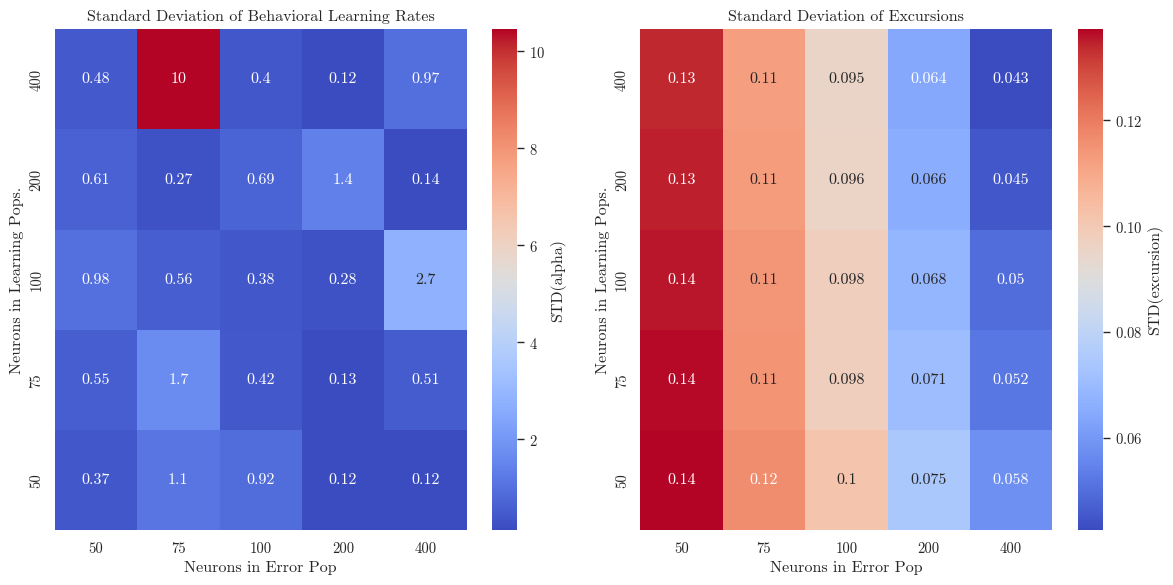

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
alpha_pivot = combined.pivot_table(index='n_learning', columns='n_error', values='alpha', aggfunc='std')
excursion_pivot = combined.pivot_table(index='n_learning', columns='n_error', values='excursion', aggfunc='std')
sns.heatmap(data=alpha_pivot, annot=True, cmap="coolwarm", cbar_kws={'label': 'STD(alpha)'}, ax=axes[0])
sns.heatmap(data=excursion_pivot, annot=True, cmap="coolwarm", cbar_kws={'label': 'STD(excursion)'}, ax=axes[1])
axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[0].set(ylabel="Neurons in Learning Pops.", xlabel="Neurons in Error Pop", title="Standard Deviation of Behavioral Learning Rates")
axes[1].set(ylabel="Neurons in Learning Pops.", xlabel="Neurons in Error Pop", title="Standard Deviation of Excursions")
plt.tight_layout()
# fig.savefig("plots/noise_RL_vs_neurons.jpg", dpi=600)

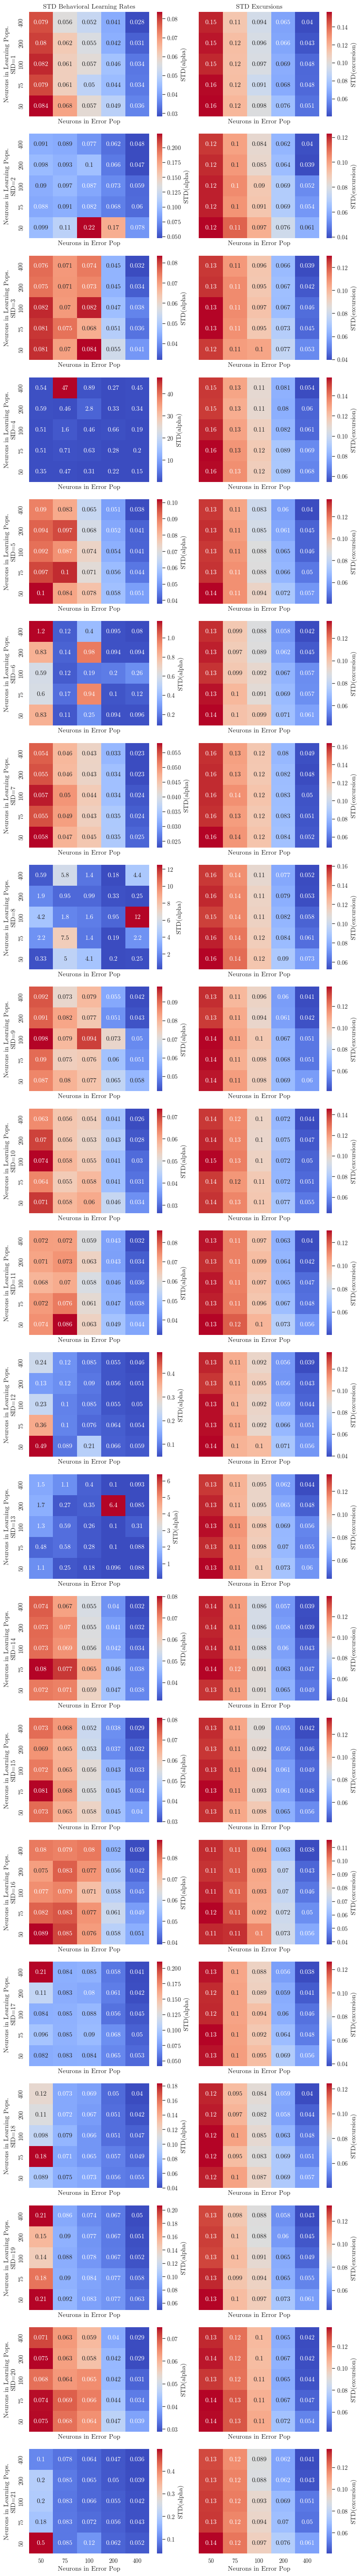

In [16]:
fig, axes = plt.subplots(nrows=len(combined['sid'].unique()), ncols=2, figsize=(9,3*len(combined['sid'].unique())), sharex=True, sharey=True)
for s, sid in enumerate(combined['sid'].unique()):
    alpha_pivot = combined.query("sid==@sid").pivot_table(index='n_learning', columns='n_error', values='alpha', aggfunc='std')
    excursion_pivot = combined.query("sid==@sid").pivot_table(index='n_learning', columns='n_error', values='excursion', aggfunc='std')
    sns.heatmap(data=alpha_pivot, annot=True, cmap="coolwarm", cbar_kws={'label': 'STD(alpha)'}, ax=axes[s][0])
    sns.heatmap(data=excursion_pivot, annot=True, cmap="coolwarm", cbar_kws={'label': 'STD(excursion)'}, ax=axes[s][1])
    # axes[s][0].invert_yaxis()
    axes[s][1].invert_yaxis()
    axes[s][0].set(ylabel=f"Neurons in Learning Pops.\nSID={sid}", xlabel="Neurons in Error Pop")
    axes[s][1].set(ylabel=None, xlabel="Neurons in Error Pop")
axes[0][0].set(title="STD Behavioral Learning Rates")
axes[0][1].set(title="STD Excursions")
plt.tight_layout()
# fig.savefig("plots/noise_RL_vs_neurons_all_sids.jpg", dpi=200)

### Compare to distribution of std(alpha) and std(excursion) across human SIDs

In [9]:
human = pd.read_pickle("data/carrabin.pkl")
human['n_learning'] = 'human'
human['n_error'] = 'human'
human_add = add_excursion_alpha(human)
dfs = []
columns = ['type', 'sid', 'std alpha', 'std excursion']
for sid in human_add['sid'].unique():
    std_alpha = human_add.query("sid==@sid")['alpha'].std()
    std_excursion = human_add.query("sid==@sid")['excursion'].std()
    dfs.append(pd.DataFrame([['human', sid, std_alpha, std_excursion]], columns=columns))
human_stds = pd.concat(dfs, ignore_index=True)

human sid 1, n_learning human, n_error human
human sid 2, n_learning human, n_error human
human sid 3, n_learning human, n_error human
human sid 4, n_learning human, n_error human
human sid 5, n_learning human, n_error human
human sid 6, n_learning human, n_error human
human sid 7, n_learning human, n_error human
human sid 8, n_learning human, n_error human
human sid 9, n_learning human, n_error human
human sid 10, n_learning human, n_error human
human sid 11, n_learning human, n_error human
human sid 12, n_learning human, n_error human
human sid 13, n_learning human, n_error human
human sid 14, n_learning human, n_error human
human sid 15, n_learning human, n_error human
human sid 16, n_learning human, n_error human
human sid 17, n_learning human, n_error human
human sid 18, n_learning human, n_error human
human sid 19, n_learning human, n_error human
human sid 20, n_learning human, n_error human
human sid 21, n_learning human, n_error human


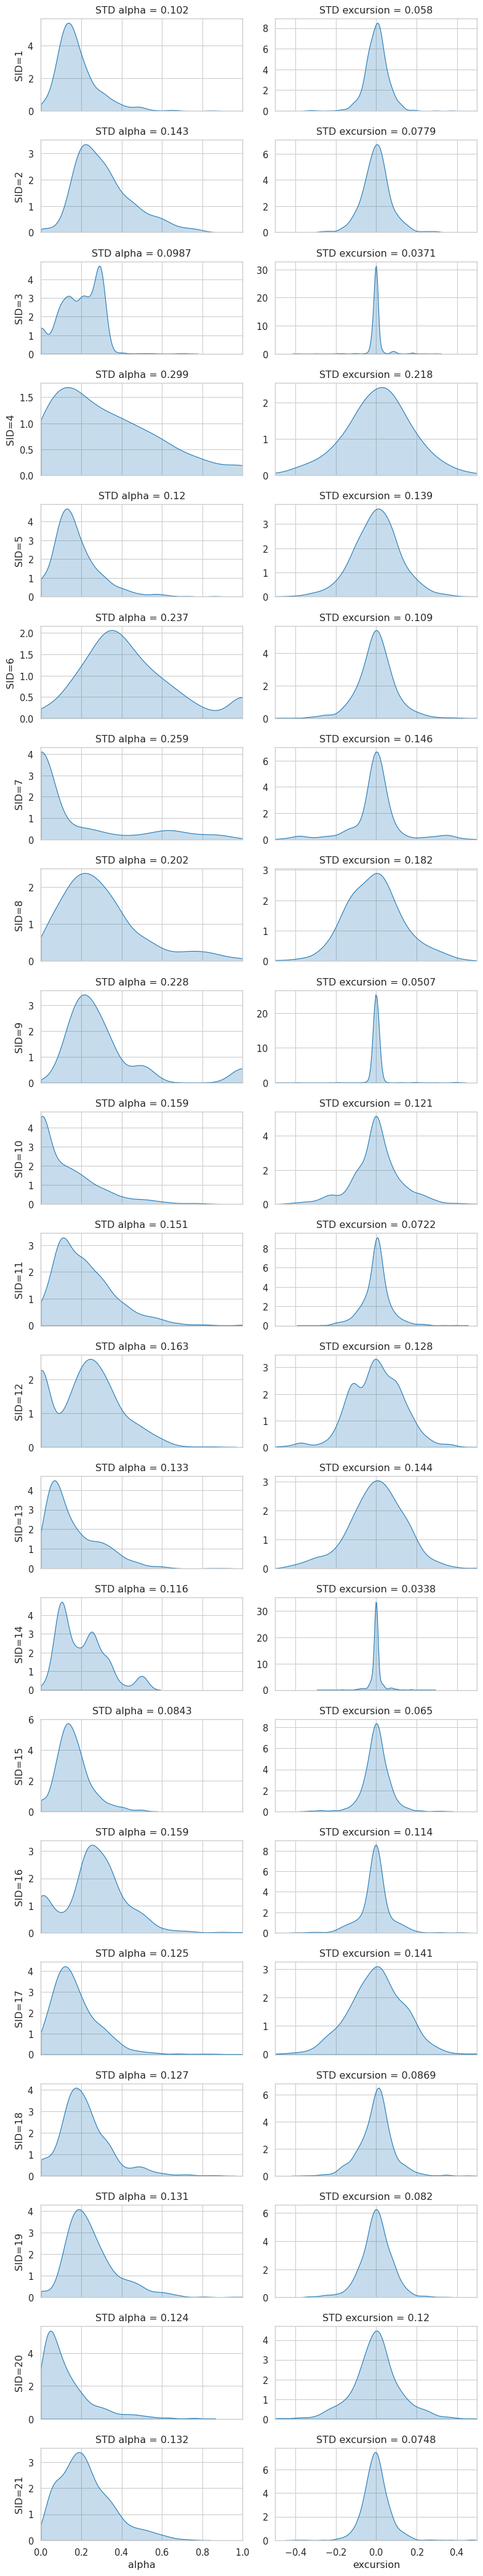

In [10]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(nrows=len(human['sid'].unique()), ncols=2, figsize=(8,2*len(human['sid'].unique())), sharex='col')
    for s, sid in enumerate(human['sid'].unique()):
        sns.kdeplot(human_add.query("sid==@sid"), x='alpha', clip=[0,1], ax=axes[s][0], color=palette[0], fill=True, common_norm=False)
        sns.kdeplot(human_add.query("sid==@sid"), x='excursion', clip=[-1,1], ax=axes[s][1], color=palette[0], fill=True, common_norm=False)
        axes[s][0].set(ylabel=f"SID={sid}", title=f"STD alpha = {human_add.query('sid==@sid')['alpha'].std():.3}")
        axes[s][1].set(ylabel=None, title=f"STD excursion = {human_add.query('sid==@sid')['excursion'].std():.3}")
    axes[-1][0].set(xlim=[0,1])
    axes[-1][1].set(xlim=[-0.5,0.5])
    plt.tight_layout()
fig.savefig("plots/alpha_excursions_all_sids.jpg", dpi=600)